In [1]:
import math
import random
from enum import Enum

import networkx as nx

from mesa import Agent, Model
from mesa.time import StagedActivation
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from pyvis.network import Network

import math

from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
from mesa.visualization.modules import TextElement

import pandas as pd 
import numpy as np
import scipy.sparse as sps
import scipy as sp

import matplotlib.pyplot as plt

import multinetx as mx

In [2]:
def make_dict(role_list, dict_type):
    'Be aware, this function includes a lot of hardcoding, which makes it less versatile. '
    'However it does make it convenient for choosing exact colors for specific roles. '
    'It is important to have the same order of roles as much as possible. '
    
    # Set color dict
    if dict_type == 'color':
        return_dict = {role_list[0]: 'red'} | dict.fromkeys(role_list[1], 'orange') | \
        dict.fromkeys(role_list[2], 'yellow') | dict.fromkeys(role_list[3], 'blue') | \
        dict.fromkeys(role_list[4], 'green') | dict.fromkeys(role_list[5], 'pink')
        
    # Set business name dict
    elif dict_type == 'business_name':
        return_dict = {role_list[0]: 'kingpin_main'} | \
        {c:'kingpin_'+str(i) for i, c in enumerate(role_list[1])} | \
        {c:'orphan_'+str(i) for i, c in enumerate(role_list[2])} | \
        {c:'broker_'+str(i) for i, c in enumerate(role_list[3])} | \
        {c:'dealer_'+str(i) for i, c in enumerate(role_list[4])} | \
        {c:'coordinator_'+str(i) for i, c in enumerate(role_list[5])}
        
    # Set family name dict
    elif dict_type == 'family_name':
        return_dict = {role_list[0]: 'father_main'} | \
        {c:'cousin_'+str(i) for i, c in enumerate(role_list[1])} | \
        {c:'brother_'+str(i) for i, c in enumerate(role_list[2])} | \
        {c:'friend_'+str(i) for i, c in enumerate(role_list[3])} | \
        {c:'driver_'+str(i) for i, c in enumerate(role_list[4])} | \
        {c:'contact_'+str(i) for i, c in enumerate(role_list[5])}
        
    elif dict_type == 'weight':
        return_dict = {role_list[0]: 100} | dict.fromkeys(role_list[1], 75) | \
        dict.fromkeys(role_list[2], 90) | dict.fromkeys(role_list[3], 50) | \
        dict.fromkeys(role_list[4], 40) | dict.fromkeys(role_list[5], 30)
        
    return return_dict

In [3]:
def add_edge_list(G, role_list1, role_list2, prob, role_color, role_weight, interconnected=False):
    'Function to add edges according to the input parameters'
    
    # Regular edges
    for c in role_list1:
        edge_list = []
        for x in role_list2:
            if ((c is not x) and (random.uniform(0, 1) < prob)):
                if (c, x) in G.edges():
                    G.remove_edge(c, x)
                elif (x, c) in G.edges():
                    G.remove_edge(x, c)
                edge_list += [(c, x)]
            
        violence_list = [random.uniform(0, 1) for i in range(len(edge_list))]
        G.add_edges_from(edge_list, color=role_color, weight=role_weight)   
    
    # Interconnected edges between same group
    if interconnected:
        for c in role_list1:
            edge_list = []
            for x in role_list1:
                if c is not x:
                    if (c, x) in G.edges():
                        G.remove_edge(c, x)
                    elif (x, c) in G.edges():
                        G.remove_edge(x, c)
                    edge_list += [(c, x)]
                
            violence_list = [random.uniform(0, 1) for i in range(len(edge_list))]
            G.add_edges_from(edge_list, color=role_color, weight=role_weight)   


In [4]:
# NOTE: when changing the trust/violence variables in the dictionary, note that right now the numbers are 50, but
#       they should be between 0 and 1, as that is the case for all other trust/violence variables as well

edge_violence_social = {'FAT_COU': 50, 'FAT_BRO': 50, 'FAT_FRI': 50, 'FAT_DRI': 50, 'FAT_CON': 50, \
                        'COU_FAT': 50, 'COU_BRO': 50, 'COU_FRI': 50, 'COU_DRI': 50, 'COU_CON': 50, \
                        'BRO_FAT': 50, 'BRO_COU': 50, 'BRO_FRI': 50, 'BRO_DRI': 50, 'BRO_CON': 50, \
                        'FRI_FAT': 50, 'FRI_COU': 50, 'FRI_BRO': 50, 'FRI_DRI': 50, 'FRI_CON': 50, \
                        'DRI_FAT': 50, 'DRI_COU': 50, 'DRI_BRO': 50, 'DRI_FRI': 50, 'DRI_CON': 50, \
                        'CON_FAT': 50, 'CON_COU': 50, 'CON_BRO': 50, 'CON_FRI': 50, 'CON_DRI': 50, \
                        'FAT_FAT': 50, 'COU_COU': 50, 'BRO_BRO': 50, 'FRI_FRI': 50, 'DRI_DRI': 50, 'CON_CON': 50}

edge_trust_social = {'FAT_COU': 50, 'FAT_BRO': 50, 'FAT_FRI': 50, 'FAT_DRI': 50, 'FAT_CON': 50, \
                     'COU_FAT': 50, 'COU_BRO': 50, 'COU_FRI': 50, 'COU_DRI': 50, 'COU_CON': 50, \
                     'BRO_FAT': 50, 'BRO_COU': 50, 'BRO_FRI': 50, 'BRO_DRI': 50, 'BRO_CON': 50, \
                     'FRI_FAT': 50, 'FRI_COU': 50, 'FRI_BRO': 50, 'FRI_DRI': 50, 'FRI_CON': 50, \
                     'DRI_FAT': 50, 'DRI_COU': 50, 'DRI_BRO': 50, 'DRI_FRI': 50, 'DRI_CON': 50, \
                     'CON_FAT': 50, 'CON_COU': 50, 'CON_BRO': 50, 'CON_FRI': 50, 'CON_DRI': 50, \
                     'FAT_FAT': 50, 'COU_COU': 50, 'BRO_BRO': 100, 'FRI_FRI': 50, 'DRI_DRI': 50, 'CON_CON': 50}

edge_trust_business = {'KIM_KIP': 50, 'KIM_ORP': 50, 'KIM_BRK': 50, 'KIM_DEA': 50, 'KIM_COR': 50, \
                     'KIP_KIM': 50, 'KIP_ORP': 50, 'KIP_BRK': 50, 'KIP_DEA': 50, 'KIP_COR': 50, \
                     'ORP_KIM': 50, 'ORP_KIP': 50, 'ORP_BRK': 50, 'ORP_DEA': 50, 'ORP_COR': 50, \
                     'BRK_KIM': 50, 'BRK_KIP': 50, 'BRK_ORP': 50, 'BRK_DEA': 50, 'BRK_COR': 50, \
                     'DEA_KIM': 50, 'DEA_KIP': 50, 'DEA_ORP': 50, 'DEA_BRK': 50, 'DEA_COR': 50, \
                     'COR_KIM': 50, 'COR_KIP': 50, 'COR_ORP': 50, 'COR_BRK': 50, 'COR_DEA': 50, \
                     'KIM_KIM': 50, 'KIP_KIP': 50, 'ORP_ORP': 50, 'BRK_BRK': 50, 'DEA_DEA': 50, 'COR_COR': 50}
      

def get_violtrust(edge_ID):
    
    viol = edge_violence_social[edge_ID]
    trus = edge_trust_social[edge_ID]
    
    return viol, trus

def get_semirandom_trust(edge_ID):
    
    ran_change = random.uniform(-0.25, 0.25)
    trus = edge_trust_business[edge_ID] 
    
    final_trust = max(min((trus + ran_change), 1), 0)
    
    return final_trust
    
    
def get_edgeID(G, element, name_dict):
    role_1 = name_dict[element[0]]
    role_2 = name_dict[element[1]]
    
    string_1 = get_role_char(role_1)
    string_2 = get_role_char(role_2)
    
    return string_1 + '_' + string_2
    
def get_role_char(role):
    
    if 'father' in role:
        return 'FAT'
    
    elif 'cousin' in role:
        return 'COU'
    
    elif 'brother' in role:
        return 'BRO'
    
    elif 'friend' in role:
        return 'FRI'
    
    elif 'driver' in role:
        return 'DRI'
    
    elif 'contact' in role:
        return 'CON'
    
    elif 'kingpin_main' in role:
        return 'KIM'
    
    elif 'kingpin' in role:
        return 'KIP'
    
    elif 'orphan' in role:
        return 'ORP'
    
    elif 'broker' in role:
        return 'BRK'
    
    elif 'dealer' in role:
        return 'DEA'
    
    elif 'coordinator' in role:
        return 'COR'
    
    else:
        return 'NONE'
    
def change_ID(old_string, kim_num, edge_nums):
    
    if kim_num == edge_nums[0]:
        return 'KIM' + old_string[4:7]
    elif kim_num == edge_nums[1]:
        return old_string[0:4] + 'KIM'
    else:
        return 'NONE'

In [5]:
# Function to create list of connected networks ('N>30')
def create_networks(networks, N=30):
    'Function to create the networks involved'
    # Return list with created networks
    network_list = []
    
    # Create IDs for agents
    shuffled = random.sample(range(0, N), N)
    shuffledf = random.sample(range(0, N), N)

    # Set roles business
    kingpin_main = shuffled[0]
    kingpin_list = shuffled[1:4]
    orphan_list = shuffled[4:8]
    broker_list = shuffled[8:16]
    dealer_list = shuffled[16:23]
    coordinator_list = shuffled[23:N]
    
    # set roles family/social
    father_main = shuffled[0]
    cousin_list = shuffled[1:4]
    brother_list = shuffled[4:8]
    friend_list = shuffled[8:16]
    driver_list = shuffled[16:23]
    contact_list = shuffled[23:N]
    
    # Create business/social role lists
    business_role_list = [kingpin_main, kingpin_list, orphan_list, broker_list, dealer_list, coordinator_list]
    family_role_list = [father_main, cousin_list, brother_list, friend_list, driver_list, contact_list]
    
    # Make dictionaries for attributes
    business_color_dict = make_dict(business_role_list, 'color')
    family_color_dict = make_dict(family_role_list, 'color')
    business_name_dict = make_dict(business_role_list, 'business_name')
    family_name_dict = make_dict(family_role_list, 'family_name')
    business_weight_dict = make_dict(business_role_list, 'weight')
    family_weight_dict = make_dict(family_role_list, 'weight')
        
    # Create each network
    for name in networks:
        
        # Start with empty network
        G = nx.empty_graph(N)
        
        # Set names, colours and weights
        nx.set_node_attributes(G, business_name_dict, "business_name")
        nx.set_node_attributes(G, family_name_dict, "family_name")
        nx.set_node_attributes(G, business_color_dict, "business_color")
        nx.set_node_attributes(G, family_color_dict, "family_color")
        nx.set_node_attributes(G, business_weight_dict, "business_weight")
        nx.set_node_attributes(G, family_weight_dict, "family_weight")
        
        # For business network
        if name == 'business':
            
            # Add edge lists including weight and colours
            add_edge_list(G, coordinator_list, G.nodes(), 0.1, 'pink', 30) 
            add_edge_list(G, dealer_list, G.nodes(), (1/6), 'green', 50) 
            add_edge_list(G, broker_list, G.nodes(), 0.25, 'blue', 70) 
            add_edge_list(G, orphan_list, G.nodes(), (1/3), 'yellow', 80, True) 
            add_edge_list(G, kingpin_list, G.nodes(), 0.25, 'orange', 100)
            add_edge_list(G, [kingpin_main], G.nodes(), 1, 'red', 100)
            
            # Assign random values to violence and trust
            violence_dict = dict()
            trust_dict = dict()
            usefulness_dict = dict()
            edgeID_dict = dict()
            for element in G.edges():
                edge_ID = get_edgeID(G, element, business_name_dict)
                edgeID_dict[element] = edge_ID
                violence_dict[element] = random.uniform(0, 1)
                trust_dict[element] = get_semirandom_trust(edge_ID)
                usefulness_dict[element] = random.uniform(0.3,1)
                
            nx.set_edge_attributes(G, violence_dict, name="edge_violence")
            nx.set_edge_attributes(G, trust_dict, name="edge_trust")
            nx.set_edge_attributes(G, usefulness_dict, name="edge_usefulness")
            nx.set_edge_attributes(G, edgeID_dict, name="edge_ID")

            # Append network for returning
            network_list.append(G)

            # Get node and edge colours for drawing
            business_values = [business_color_dict.get(node, 'k') for node in G.nodes()]
            edge_colors = nx.get_edge_attributes(G,'color').values()
            
            # Draw network
            nx.draw(G, with_labels=True, edge_color=edge_colors, node_color=business_values)
            plt.show()
            
        # For social network
        if name == 'social':
            
            # Add edge lists including weight and colours
            add_edge_list(G, driver_list, contact_list, 1, 'green', 50, True) 
            add_edge_list(G, friend_list, driver_list, 1, 'blue', 70, True) 
            add_edge_list(G, brother_list, friend_list, 1, 'yellow', 80, True) 
            add_edge_list(G, cousin_list, friend_list, 1, 'orange', 70, True) 
            add_edge_list(G, [father_main], G.nodes(), 1, 'red', 100, True) 
            
            # Assign values based on roles to violence and trust
            violence_dict = dict()
            trust_dict = dict()
            edgeID_dict = dict()
            for element in G.edges():
                edge_ID = get_edgeID(G, element, family_name_dict)
                edgeID_dict[element] = edge_ID
                viol, trus = get_violtrust(edge_ID)
                violence_dict[element] = viol
                trust_dict[element] = trus
                
            nx.set_edge_attributes(G, violence_dict, name="edge_violence")
            nx.set_edge_attributes(G, trust_dict, name="edge_trust")
            nx.set_edge_attributes(G, edgeID_dict, name="edge_ID")

            # Append network for returning
            network_list.append(G)           
                
            # Get node and edge colours for drawing
            family_colors = nx.get_edge_attributes(G,'color').values()
            family_values = [family_color_dict.get(node, 'k') for node in G.nodes()]

            # Draw network
            nx.draw(G, with_labels=True, edge_color=family_colors, node_color=family_values)
            plt.show()

    return network_list

In [6]:
class Agents(Agent):
    def __init__ (self, unique_ID, model, gender):
        'Initialisation function of model'
        super(). __init__(unique_ID, model)
    
        self.ID = unique_ID
        self.violence = random.uniform(0,1)
        self.trust = random.uniform(0,1)
        self.usefulness = random.uniform(0.3,1)
        if random.uniform(0,1) < gender:
            self.gen = "m"
        else:
            self.gen = "f"
    
    def step(self):
        print('test')
        
    def stage1(self):
        print('stage1')
        
    def stage2(self):
        print('stage2')
        
    def stage3(self):
        print('stage3')
    
    def stage4(self):
        print('stage4')

In [7]:
class ReplacementModel(Model):
    
    def __init__ (self, phase, gender_choosing):
        'Initialisation function of model'
        self.schedule = StagedActivation(self, stage_list = ['stage1', 'stage2', 'stage3', 'stage4'])
        
        # Create and store networks
        self.nets = create_networks(['business', 'social'])
        self.business = self.nets[0]
        self.social = self.nets[1]
        self.business_visualisation = [self.business]
        self.social_visualisation = [self.social]
        
        self.phase = 'start'
        self.steps = 0
        self.interval = -1
        self.end = -1
        
        self.violence = -1
        self.trust = -1
        self.usefulness = -1
        
        # Store information dictionaries
        self.business_name_dict = nx.get_node_attributes(self.business,'business_name')
        self.family_name_dict = nx.get_node_attributes(self.social,'family_name')
        self.business_color_dict = nx.get_node_attributes(self.business,'business_color')
        self.family_color_dict = nx.get_node_attributes(self.social,'family_color')
        self.business_edge_colors = nx.get_edge_attributes(self.business,'color')
        self.family_edge_colors = nx.get_edge_attributes(self.social,'color')
        self.business_trust_edges = nx.get_edge_attributes(self.business, 'edge_trust')
        self.business_violence_edges = nx.get_edge_attributes(self.business, 'edge_violence')
        self.business_usefulness_edges = nx.get_edge_attributes(self.business, 'edge_usefulness')
        self.business_edgeIDs = nx.get_edge_attributes(self.business, 'edge_ID')
        self.family_trust_edges = nx.get_edge_attributes(self.social, 'edge_trust')
        self.family_violence_edges = nx.get_edge_attributes(self.social, 'edge_violence')
        self.family_edgeIDs = nx.get_edge_attributes(self.social, 'edge_ID')
        
        # Orphanlist
        self.orphans = [key for key, value in self.business_name_dict.items() if 'orphan' in value]
        self.kingpin_main = [key for key, value in self.business_name_dict.items() if 'kingpin_main' == value][0]

        # Add all nodes to schedule
        for node in self.business:
            a = Agents(node, self, gender_choosing)
            self.schedule.add(a)
            
        # Add additional info
        self.potential = -1
        
        # Data Collection
        self.datacollector = DataCollector(
            model_reporters={"Phases": 'phase',
                            "Business": 'business',
                            "Social": 'social'})
        
    def remove_king(self):
        'Function to remove king'
        names=nx.get_node_attributes(self.business,'business_name')
        for agent in model.schedule.agents:
            if names[agent.ID] == 'kingpin_main':
                self.business.remove_node(agent.ID)
                self.social.remove_node(agent.ID)
                self.schedule.remove(agent)
                self.update_dicts()
                self.phase = 'removed'
 
    def connect_node(self):
        'Function to find replacement'
        names=nx.get_node_attributes(self.business,'business_name')
        best_trust = 0
        for agent in model.schedule.agents:
#             if 'kingpin' in names[agent.ID]:
            trust_level = 0
            for o in self.orphans:
                if (agent.ID, o) in self.business_trust_edges:
                    trust_level += self.business_trust_edges[(agent.ID, o)]
                elif (o, agent.ID) in self.business_trust_edges:
                    trust_level += self.business_trust_edges[(o, agent.ID)]

            if trust_level > best_trust:
                best_trust = trust_level
                best_potential = agent.ID
                
        self.potential = best_potential
        self.link_orphans(agent)
        self.update_dicts()
        self.phase = 'chosen'
    
    def link_orphans(self, agent):
        
        # check whether edge attributes will be overwritten??
        add_edge_list(self.business, [agent.ID], self.orphans, 1, 'lightblue', 70)
        
        
        for o in self.orphans:
            if (agent.ID, o) not in self.business_trust_edges and (o, agent.ID) not in self.business_trust_edges:
                self.business_trust_edges[(o, agent.ID)] = random.uniform(0.35,0.65)
                
        nx.set_edge_attributes(self.business, self.business_trust_edges, 'edge_trust')
        self.update_dicts()
        
    def pick_kingpin(self):
        trust_total = 0
        for o in self.orphans:
            if (self.potential, o) in self.business_trust_edges:
                trust_total += self.business_trust_edges[(self.potential, o)]
            elif (o, self.potential) in self.business_trust_edges:
                trust_total += self.business_trust_edges[(o, self.potential)]
                
        if (trust_total / len(self.orphans)) > 0.55:
            self.phase = 'picked'
            self.update_links()
            self.end = self.steps + 10
        else:
            self.phase = 'removed+'
            
    def update_links(self):
        
        # TODO social edge attributes 
        
        self.kingpin_main = self.potential
        self.potential = -1
        
        self.business_name_dict[self.kingpin_main] = 'kingpin_main'
        self.business_color_dict[self.kingpin_main] = 'red'
        self.family_color_dict[self.kingpin_main] = 'red'
        
        nx.set_node_attributes(self.business, self.business_name_dict, "business_name")
        nx.set_node_attributes(self.business, self.business_color_dict, "business_color")
        nx.set_node_attributes(self.social, self.family_color_dict, "family_color")

        # check whether edge attributes will be overwritten??
        add_edge_list(self.business, [self.kingpin_main], self.business.nodes(), 1, 'red', 70)
        add_edge_list(self.social, [self.kingpin_main], self.social.nodes(), 1, 'red', 70)
        
        for edge in self.business.edges():
            if self.kingpin_main in edge:
                if edge in self.business_edgeIDs:
                    self.business_edgeIDs[edge] = change_ID(self.business_edgeIDs[edge], self.kingpin_main, edge)
              
        for node in self.business.nodes():
            if self.kingpin_main is not node:
                if (self.kingpin_main, node) in self.business_trust_edges:
                    self.business_trust_edges[(self.kingpin_main, node)] = \
                    self.business_trust_edges[(self.kingpin_main, node)] * 0.2
                elif (node, self.kingpin_main) in self.business_trust_edges:
                    self.business_trust_edges[(node, self.kingpin_main)] = \
                    self.business_trust_edges[(node, self.kingpin_main)] * 0.2
                else:
                    self.business_trust_edges[(self.kingpin_main, node)] = random.uniform(0.3, 0.65)

                if ((self.kingpin_main, node) not in self.business_violence_edges) \
                and ((node, self.kingpin_main) not in self.business_violence_edges):
                    self.business_violence_edges[(self.kingpin_main, node)] = \
                    self.get_new_violence(self.kingpin_main, node)                    
                        
        nx.set_edge_attributes(self.business, self.business_trust_edges, 'edge_trust')
        nx.set_edge_attributes(self.business, self.business_violence_edges, 'edge_violence')
        nx.set_edge_attributes(self.business, self.business_edgeIDs, 'edge_ID')
        self.update_dicts()
             
    def get_new_violence(self, kingpin, node):
        for a in self.schedule.agents:
            if a.ID == kingpin:
                kin_viol = a.violence
            elif a.ID == node:
                nod_viol = a.violence
        
        return (kin_viol + nod_viol) / 2
        
        
    def evaluate_potential(self, agent):
        trust_level = 0
        for o in self.orphans:
            if (agent.ID, o) in self.business_trust_edges:
                trust_level += self.business_trust_edges[(agent.ID, o)]
            elif (o, agent.ID) in self.business_trust_edges:
                trust_level += self.business_trust_edges[(o, agent.ID)]
                
        if (trust_level / len(self.orphans)) > 0.75:
            kingpin_main = agent.ID
            self.phase = 'chosen'
            #update name, trustlevels, connection(to everyone)
            

    def check_violence(self):
        'Function to check violence'
        violence = 0
        for agent in self.schedule.agents:
            violence += agent.violence
        violence_average = violence / len(self.schedule.agents)
        self.violence = violence_average
        
    def check_trust(self):
        'Function to check trust'
        trust = 0
        for agent in self.schedule.agents:
            trust += agent.trust
        trust_average = trust / len(self.schedule.agents)
        self.trust = trust_average
        
    def check_usefulness(self):
        'Function to check usefulness'
        usefulness = 0
        for agent in self.schedule.agents:
            usefulness += agent.usefulness
        usefulness_average = usefulness / len(self.schedule.agents)
        self.usefulness = usefulness_average


    def change_edge_trust(self):
        self.update_dicts()
        for edge in self.business.edges(): 
            
            name_string = self.family_name_dict[edge[0]] + self.family_name_dict[edge[1]]
            
            if 'brother' in self.family_name_dict[edge[0]] and 'brother' in self.family_name_dict[edge[1]]:
                self.business_trust_edges[edge] = self.business_trust_edges[edge] * 1.3
                
            elif 'cousin' in name_string and 'friend' in name_string:
                self.business_trust_edges[edge] = self.business_trust_edges[edge] * 0.7
                
            elif 'brother' in name_string and 'friend' in name_string:
                self.business_trust_edges[edge] = self.business_trust_edges[edge] * 0.4
                
            elif 'driver' in name_string and 'contact' in name_string:
                self.business_trust_edges[edge] = self.business_trust_edges[edge] * 0.2
                
            elif 'brother' in name_string and 'driver' in name_string:
                self.business_trust_edges[edge] = self.business_trust_edges[edge] * 0.2


            if self.business_trust_edges[edge] < 0.2:
                del self.business_trust_edges[edge]
                self.business.remove_edge(edge[0], edge[1])
                
            elif self.business_trust_edges[edge] > 0.8:
                self.business_trust_edges[edge] * 0.5
                
        self.phase = 'removed+'
        nx.set_edge_attributes(self.business, self.business_trust_edges, 'edge_trust')

    def ran_change_edges(self):
        self.update_dicts()
        
        for edge in self.business.edges():
            ran_trust = random.choice([-0.1, 0.1])
            ran_violence = random.choice([-0.1, 0.1])
            
            # Easy fix; trust edges get randomly assigned in case some edges are missing
            if edge in self.business_trust_edges:
                new_trust = max(min((self.business_trust_edges[edge] + ran_trust), 1), 0)
            else:
                new_trust = random.uniform(0, 1)
                
            if edge in self.business_violence_edges:
                new_violence = max(min((self.business_violence_edges[edge] + ran_violence), 1), 0)
            else:
                new_violence = random.uniform(0, 1) 
                
            self.business_trust_edges[edge] = new_trust
            self.business_violence_edges[edge] = new_violence
            
        for edge in self.social.edges():
            ran_trust = random.choice([-0.05, 0.05])
            ran_violence = random.choice([-0.05, 0.05])
            
            # Easy fix; trust edges get randomly assigned in case some edges are missing
            if edge in self.family_trust_edges:
                new_trust = max(min((self.family_trust_edges[edge] + ran_trust), 1), 0)
            else:
                new_trust = random.uniform(0, 1)
                
            if edge in self.family_violence_edges:
                new_violence = max(min((self.family_violence_edges[edge] + ran_violence), 1), 0)
            else:
                new_violence = random.uniform(0, 1) 
                
            self.family_trust_edges[edge] = new_trust
            self.family_violence_edges[edge] = new_violence
        
        nx.set_edge_attributes(self.business, self.business_trust_edges, 'edge_trust')
        nx.set_edge_attributes(self.business, self.business_violence_edges, 'edge_violence')
        nx.set_edge_attributes(self.social, self.family_trust_edges, 'edge_trust')
        nx.set_edge_attributes(self.social, self.family_violence_edges, 'edge_violence')
        self.update_dicts()
    
    def update_dicts(self):
        'Function to update information dictionaries'
        self.business_name_dict = nx.get_node_attributes(self.business,'business_name')
        self.family_name_dict = nx.get_node_attributes(self.social,'family_name')
        self.business_color_dict = nx.get_node_attributes(self.business,'business_color')
        self.family_color_dict = nx.get_node_attributes(self.social,'family_color')
        self.business_edge_colors = nx.get_edge_attributes(self.business,'color')
        self.family_edge_colors = nx.get_edge_attributes(self.social,'color')
        self.business_trust_edges = nx.get_edge_attributes(self.business, 'edge_trust')
        self.business_violence_edges = nx.get_edge_attributes(self.business, 'edge_violence')
        self.business_usefulness_edges = nx.get_edge_attributes(self.business, 'edge_usefulness')
        self.business_edgeIDs = nx.get_edge_attributes(self.business, 'edge_ID')
        self.family_trust_edges = nx.get_edge_attributes(self.social, 'edge_trust')
        self.family_violence_edges = nx.get_edge_attributes(self.social, 'edge_violence')
        self.family_edgeIDs = nx.get_edge_attributes(self.social, 'edge_ID')

    def draw_networks(self):
        'Function to draw the networks involved'
        self.update_dicts() 
        
        # Business network
        nx.draw(self.business, with_labels=True, edge_color=self.business_edge_colors.values(), \
                node_color=self.business_color_dict.values())
        plt.show()
        
        # Family network
        nx.draw(self.social, with_labels=True, edge_color=self.family_edge_colors.values(), \
                node_color=self.family_color_dict.values())
        plt.show()
        
        
    def step(self):
        'Step Function of model'
        self.datacollector.collect(self)
        # Draw network at start of each step
#         self.draw_networks()
        
        # Randomly change trust and violence edges at each step, and update averages
        self.ran_change_edges()
        self.check_violence()
        self.check_trust()
        self.check_usefulness()
        
        # Set interval variable
        self.interval = random.randrange(self.steps, self.steps + 5)
        
        # Remove king if at start and draw network
        if self.phase == 'start':
            self.remove_king()
            self.business_visualisation += [self.business]
            self.social_visualisation += [self.social]
            self.draw_networks()
            
        # If just removed, update ties accordingly
        elif self.phase == 'removed':
            self.change_edge_trust()
        
        # If removed and some time has passed
        elif (self.phase == 'removed+') and (self.steps == self.interval):
            self.connect_node()
            
        # If chosen and some more time has passed, pick kingpin
        elif (self.phase == 'chosen') and (self.steps == self.interval):
            self.business_visualisation += [self.business]
            self.social_visualisation += [self.social]
            self.pick_kingpin()
            
        # At end, draw network
        elif (self.phase == 'picked') and (self.steps == self.end):
            self.draw_networks()
            
        
    
        self.steps += 1
        
        

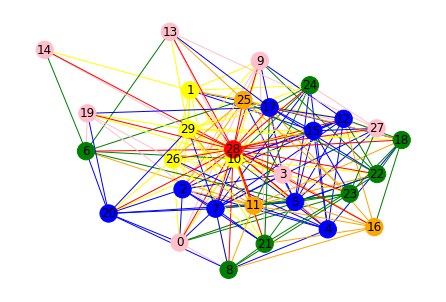

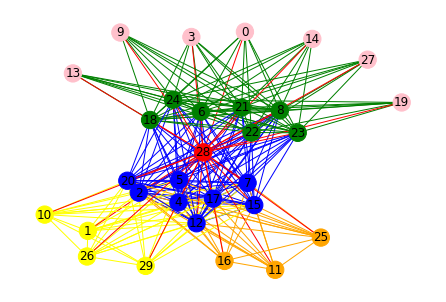

In [8]:
nets = create_networks(['business', 'social'])

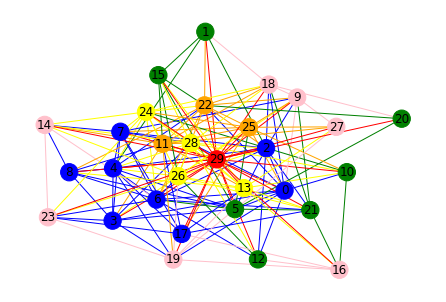

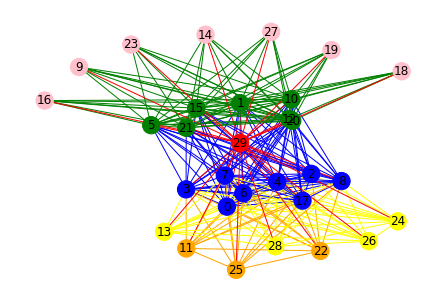

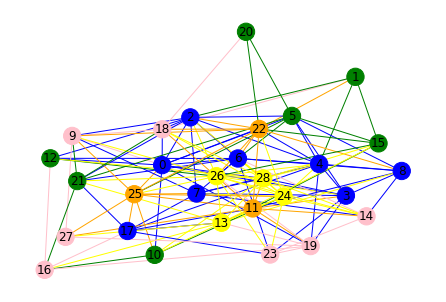

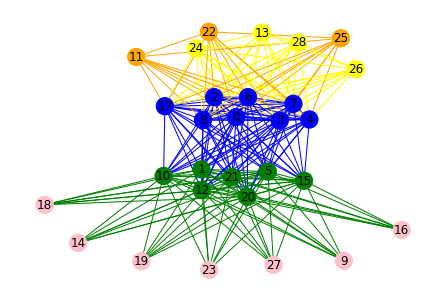

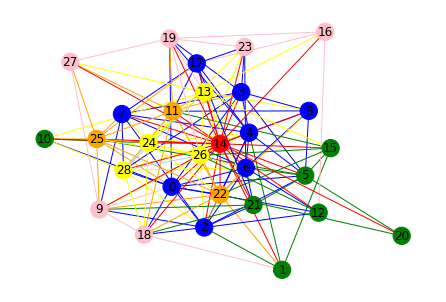

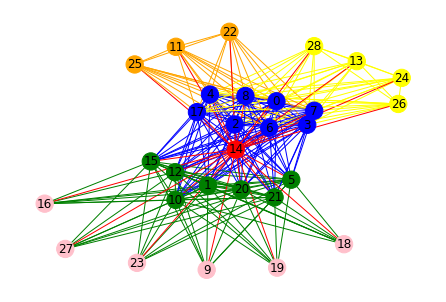

In [9]:
model = ReplacementModel('phase', 0.9)
for i in range(1000):
    model.step()

In [15]:
gini = model.datacollector.get_model_vars_dataframe()

In [26]:
model.business_visualisation

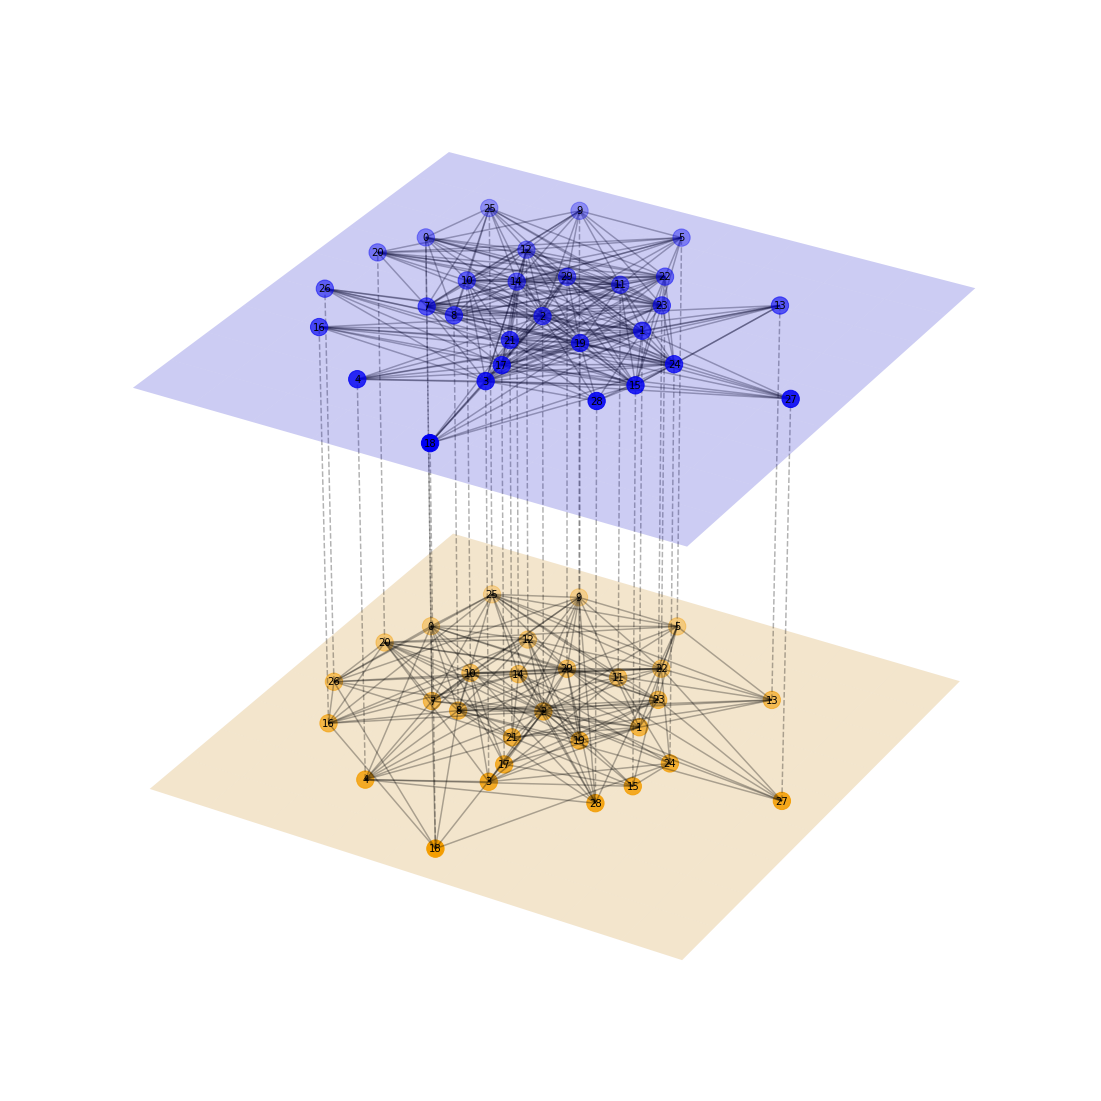

In [32]:
fig = plt.figure(figsize=(36, 20))
ax = fig.add_subplot(111, projection='3d')
node_labels = {nn : str(nn) for nn in range(30)}

for i in range(len(model.business_visualisation)):
    LayeredNetworkGraph([model.business_visualisation[i], model.social_visualisation[i]], node_labels=node_labels, ax=ax, layout=nx.spring_layout)
    ax.set_axis_off()
    plt.pause(0.5)

plt.show()



# initialise figure and plot
# fig = plt.figure(figsize=(36, 20))
# ax = fig.add_subplot(111, projection='3d')
# LayeredNetworkGraph([model.business, model.social], node_labels=node_labels, ax=ax, layout=nx.spring_layout)
# ax.set_axis_off()
# plt.show()

In [ ]:
model.business

In [10]:
"""
Plot multi-graphs in 3D.
"""
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection


class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout
        
        
        self.color_list = ['orange', 'blue', 'green', 'red', 'k']

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, color, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, color=color, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, color, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, color=color, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            color = self.color_list[z]
            self.draw_plane(z, color, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], color, s=300, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19'}


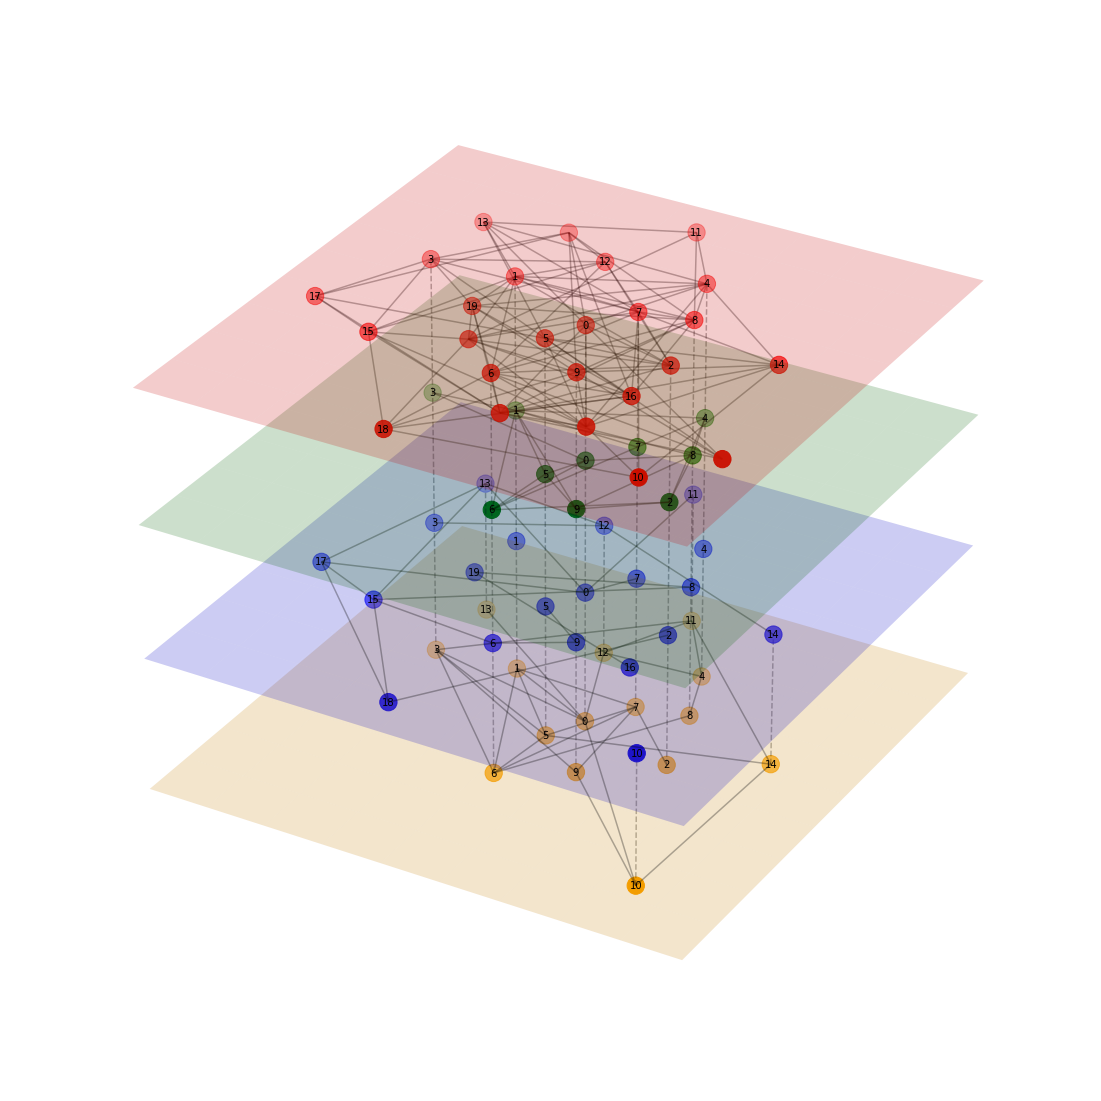

In [11]:
# define graphs
n = 5
g = nx.erdos_renyi_graph(4*n, p=0.1)
h = nx.erdos_renyi_graph(3*n, p=0.2)
i = nx.erdos_renyi_graph(2*n, p=0.4)
j = nx.erdos_renyi_graph(5*n, p=0.4)

node_labels = {nn : str(nn) for nn in range(4*n)}
print(node_labels)

# initialise figure and plot
fig = plt.figure(figsize=(36, 20))
ax = fig.add_subplot(111, projection='3d')
LayeredNetworkGraph([h, g, i, j], node_labels=node_labels, ax=ax, layout=nx.spring_layout)
ax.set_axis_off()
plt.show()

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11'}


<IPython.core.display.Javascript object>


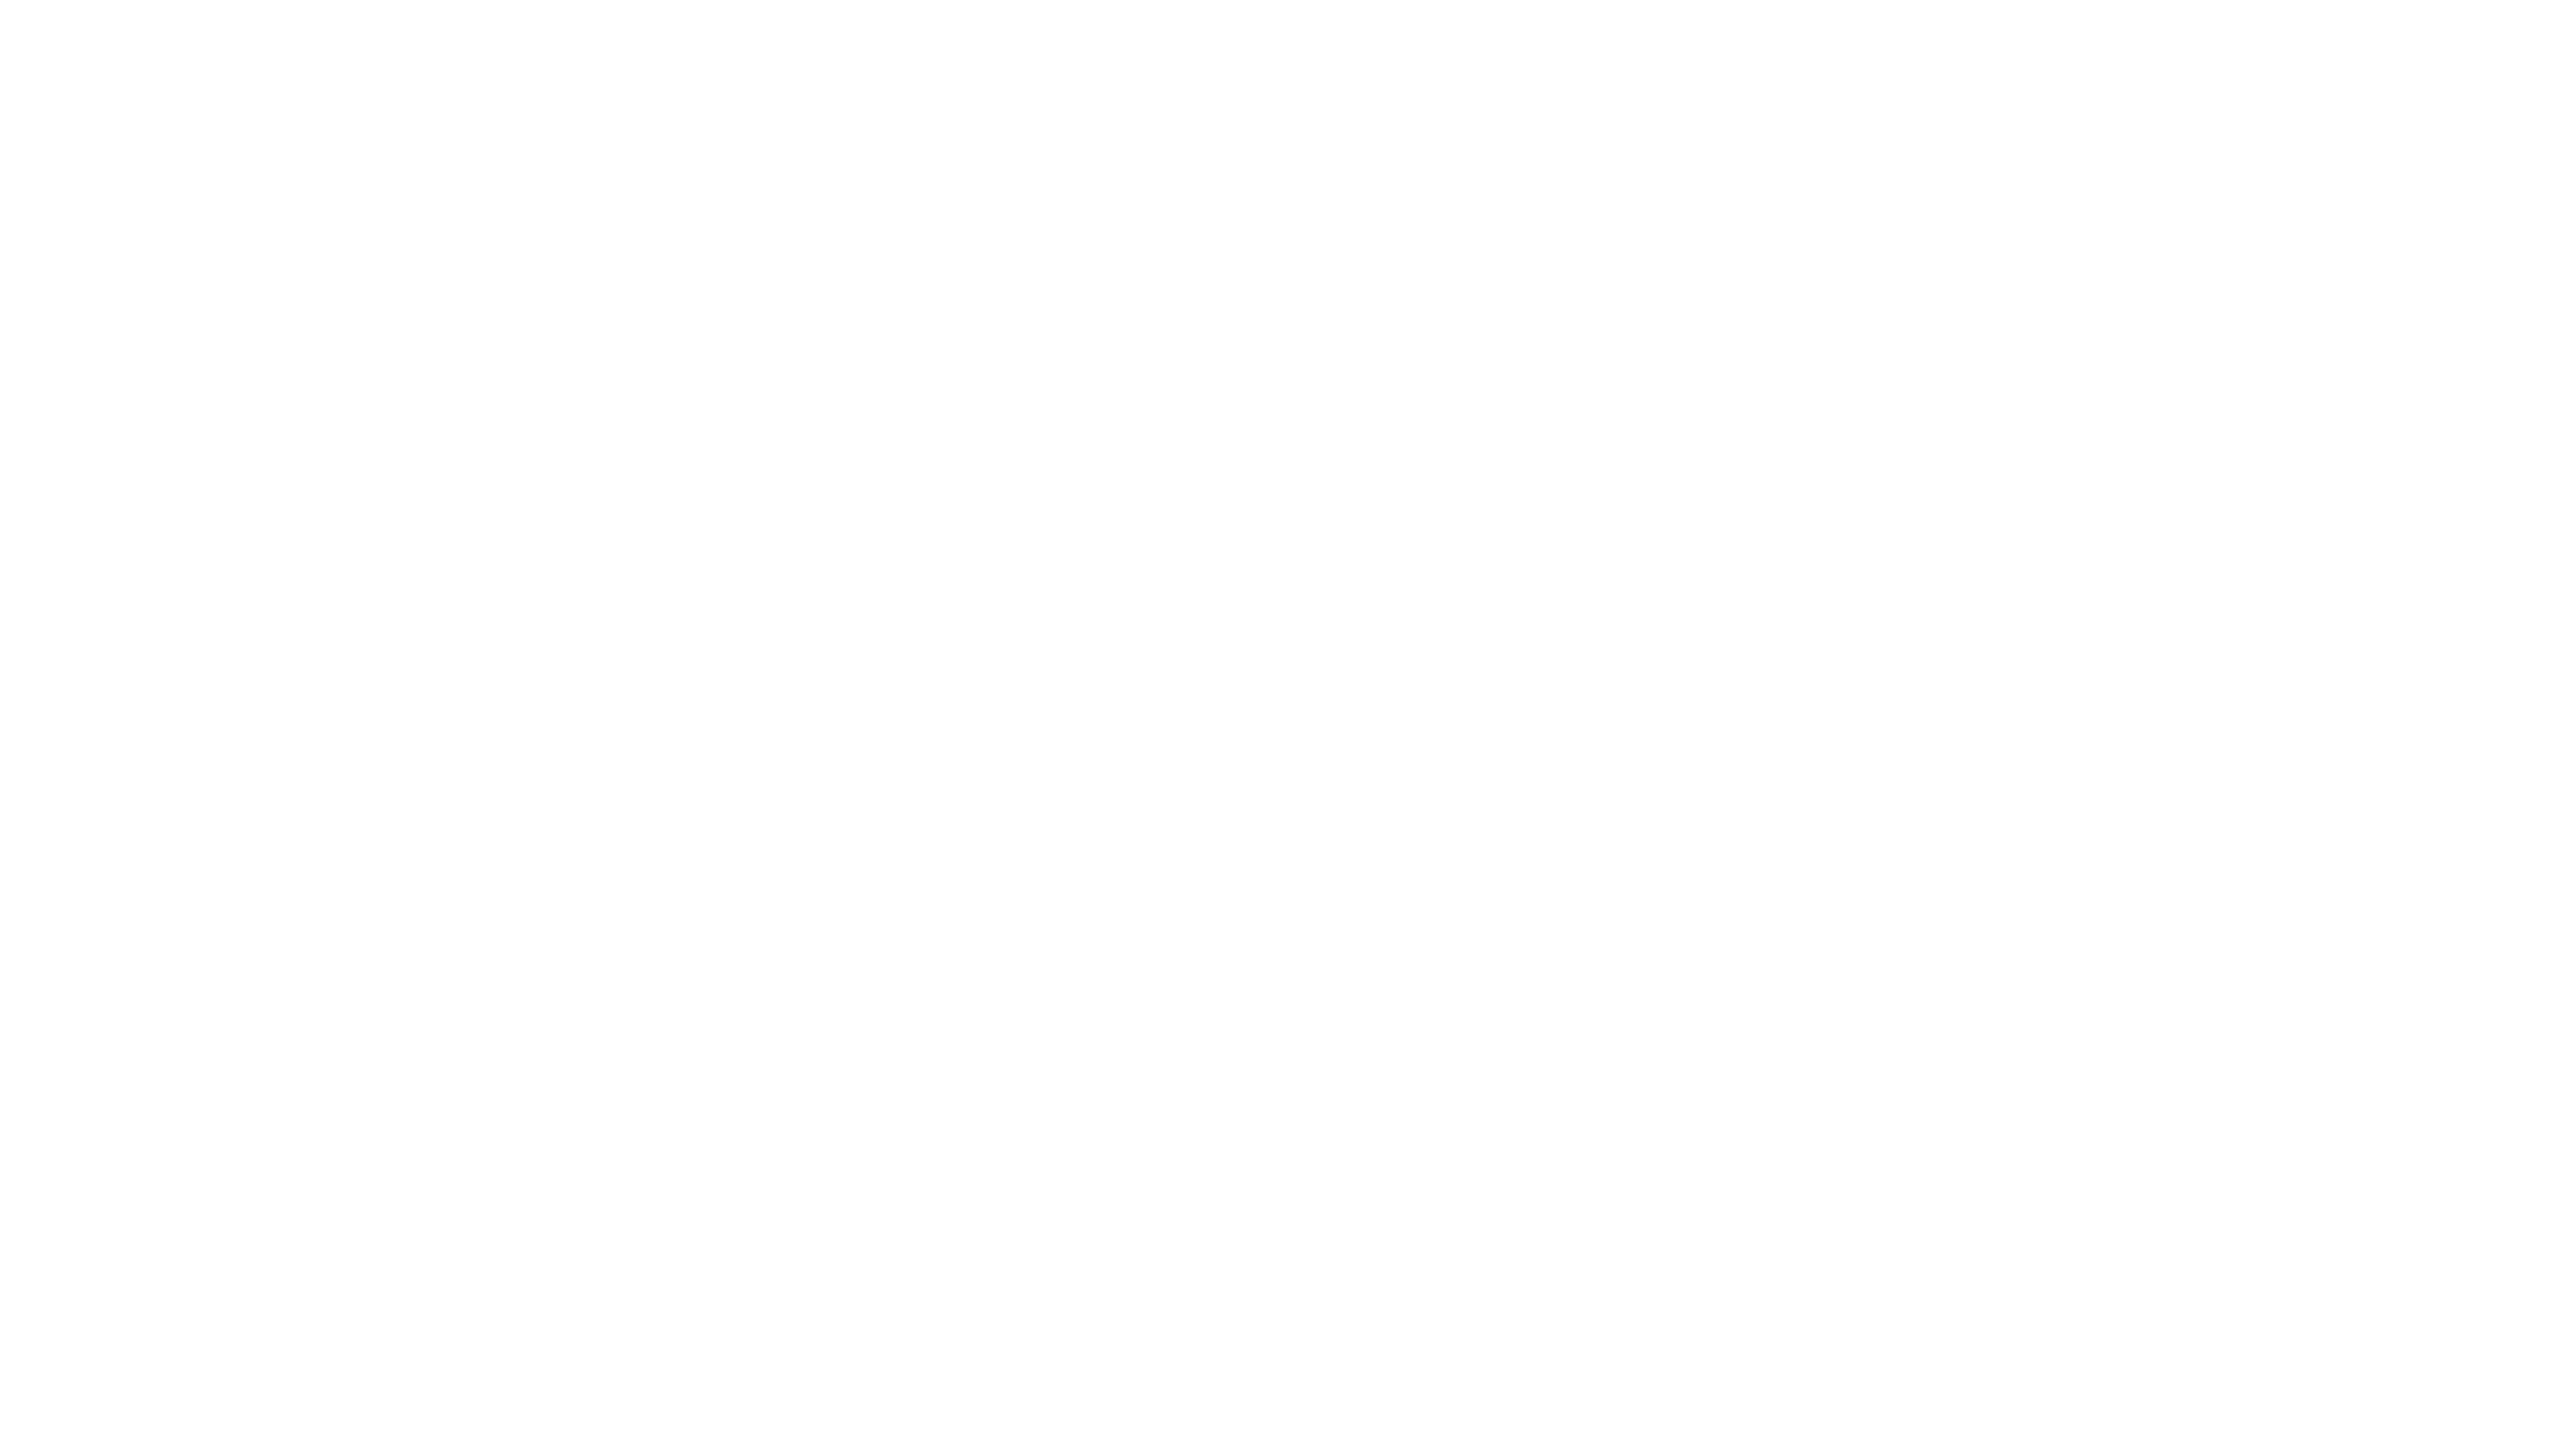

KeyboardInterrupt: 

In [14]:

# define graphs
n = 3
g = nx.erdos_renyi_graph(10*n, p=0.1)
h = nx.erdos_renyi_graph(10*n, p=0.2)
i = nx.erdos_renyi_graph(2*n, p=0.4)
j = nx.erdos_renyi_graph(2*n, p=0.4)

yes1=[i, g]
yes2 = [j, h]

node_labels = {nn : str(nn) for nn in range(4*n)}
print(node_labels)

# initialise figure and plot
fig = plt.figure(figsize=(36, 20))
ax = fig.add_subplot(111, projection='3d')
for i in range(2):
    nx.draw()
    plt.pause(5)
    plt.show()

# plt.show()

<IPython.core.display.Javascript object>


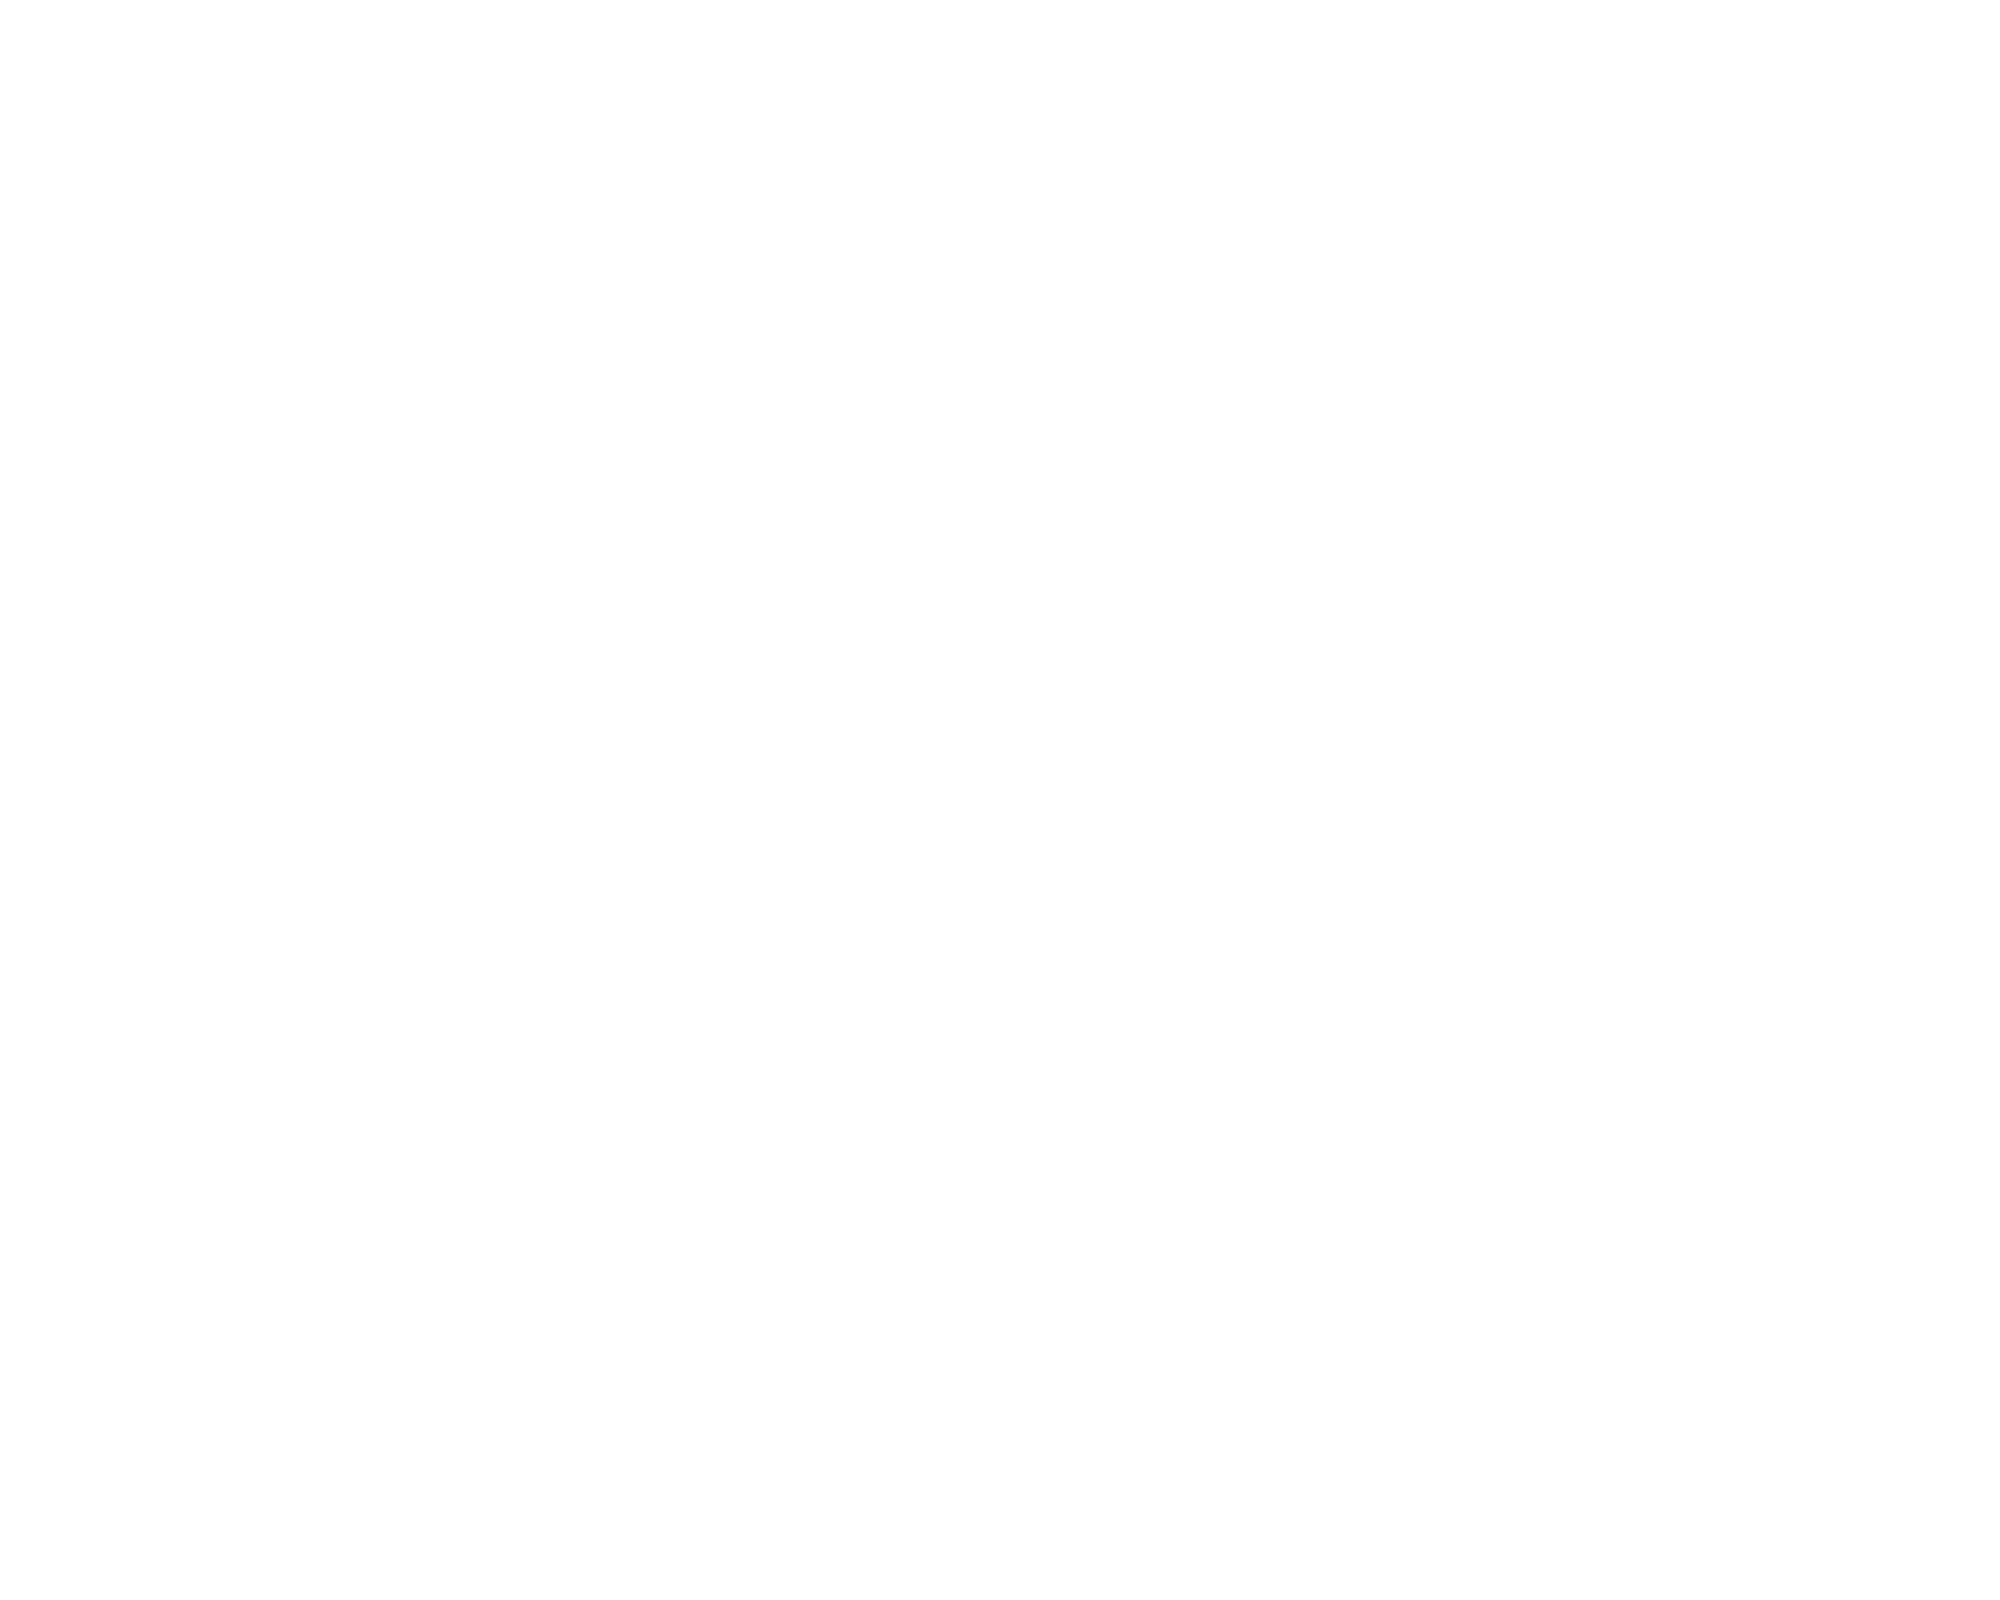

In [22]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# fig, ax = plt.subplots()

# x = np.arange(0, 2*np.pi, 0.01)
# line, = ax.plot(x, np.sin(x))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


def animate(i):
    # Business network
    nx.draw(nets[i], with_labels=True)


ani = animation.FuncAnimation(
    fig, animate, interval=2, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

In [16]:
yes1

4798


4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889


In [21]:
nets[0]

In [ ]:
def draw_networks(self):
        'Function to draw the networks involved'
        self.update_dicts() 
        
        # Business network
        nx.draw(self.business, with_labels=True, edge_color=self.business_edge_colors.values(), \
                node_color=self.business_color_dict.values())
        plt.show()
        
        # Family network
        nx.draw(self.social, with_labels=True, edge_color=self.family_edge_colors.values(), \
                node_color=self.family_color_dict.values())
        plt.show()
        